In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Path to the input MC dataset (Powheg+Pythia8) of V+jet events
file_path_mc = "/files1/home/compphys/shareddata/Vjet_PowPy8_2018_slim_Mar2025.root"
file_path_data = "/files1/home/compphys/shareddata/Vjet_data_2018_slim_Mar2025.root"

# Let's open the file and access the event tree
data_file = ROOT.TFile.Open(file_path_data,"READ")
data_tree = data_file.ZjetTree

mc_file = ROOT.TFile.Open(file_path_mc,"READ")
tree = mc_file.ZjetTree

print("The MC ZjetTree has {} events".format(tree.GetEntries()))
print("The data ZjetTree has {} events".format(data_tree.GetEntries()))

# This will print out the first event
tree.Show(0)

Welcome to JupyROOT 6.18/02
The MC ZjetTree has 2381835 events
The data ZjetTree has 431833 events


In [2]:
def extracting_data(tree, min_pT, max_pT):
    truth_pT_j1_data = []
    tree_pT_ll_data = []
    tree_pT_j1_data = []
    
    for i in range(tree.GetEntries()):
        tree.GetEntry(i)
        
          # Require pT_ref in (min,max)
        if tree.pT_ref < min_pT or tree.pT_ref > max_pT:
            continue

          # Make sure |y_j1|<0.7
        if abs(tree.yDet_j1) > 0.7:
            continue

          # ensure reco-truth matching
        if tree.truth_ll_match == 0 or tree.truth_j1_DR > 0.2:
            continue

        if tree.Dphi_ll_j1 < 2.9:
            continue  
        truth_pT_j1_data.append(tree.truth_pT_j1)
        tree_pT_ll_data.append(tree.pT_ll)
        tree_pT_j1_data.append(tree.pT_j1)
        
    truth_pT_j1_data = np.array(truth_pT_j1_data)
    tree_pT_ll_data = np.array(tree_pT_ll_data)
    tree_pT_j1_data = np.array(tree_pT_j1_data)
    
    return np.array(truth_pT_j1_data),np.array(tree_pT_ll_data),np.array(tree_pT_j1_data)
    

======> EVENT:0
 CutFlow_smalljet = 12
 NPV             = 20
 weight          = 2018.5
 m_ll            = 84.4467
 pT_ll           = 128.425
 pT_j1           = 138.617
 yDet_j1         = 0.151302
 jvt_j1          = 0.998505
 pT_j2           = 11.0084
 y_j2            = -0.545922
 jvt_j2          = 0
 Dphi_ll_j1      = 3.13013
 pT_ref          = 128.417
 R_DB            = 1.07943
 cInsitu_j1      = 1
 mu_act          = 41.5
 truth_ll_match  = 1
 truth_pT_ll     = 128.773
 truth_pT_j1     = 127.944
 truth_pT_j2     = 7.68863
 truth_z_PV      = -61.9622
 truth_Dphi_ll_j1 = 3.08589
 truth_pT_ref    = 128.574
 truth_R_DB      = 0.995107
 truth_j1_DR     = 0.00750902


In [3]:

def fastConvoluteHistos(truth_pT_j1_data, tree_pT_ll_data, tree_pT_j1_data, sigma, mean, seed=101168683):
    np.random.seed(seed)

    # Compute truth and reconstructed ratios
    truth = truth_pT_j1_data / tree_pT_ll_data
    reconstructed = tree_pT_j1_data / tree_pT_ll_data

    # Apply smearing
    smear_factors = np.random.normal(loc=mean, scale=sigma, size=len(truth))
    my_reco = truth * smear_factors

    # Apply selection cuts
    mask = (truth >= 0.5) & (truth <= 1.4)
    truth = truth[mask]
    my_reco = my_reco[mask]
    reconstructed = reconstructed[mask]

    # Bin edges
    bins = np.linspace(0.4, 1.6, 26)

    # Create histograms using NumPy
    hist_truth_vals, _ = np.histogram(truth, bins=bins)
    hist_reco_vals, _ = np.histogram(reconstructed, bins=bins)
    hist_conv_vals, _ = np.histogram(my_reco, bins=bins)

    # Convert to ROOT histograms
    hist_truth = ROOT.TH1F("", "", 25, 0.4, 1.6)
    hist_reco = ROOT.TH1F("", "", 25, 0.4, 1.6)
    hist_conv = ROOT.TH1F("", "", 25, 0.4, 1.6)

    for i in range(25):
        hist_truth.SetBinContent(i+1, hist_truth_vals[i])
        hist_reco.SetBinContent(i+1, hist_reco_vals[i])
        hist_conv.SetBinContent(i+1, hist_conv_vals[i])

    hist_truth.SetLineColor(2)
    hist_conv.SetLineColor(2)
    hist_reco.SetLineColor(4)

    hist_truth.SetStats(0)
    hist_conv.SetStats(0)
    hist_reco.SetStats(0)

    return hist_truth, hist_conv, hist_reco


In [4]:
def chi_square_calc(hist_convoluted,hist_reconstructed):
    
    hist_convoluted.SetAxisRange(0.5,1.4, "X")
    hist_reconstructed.SetAxisRange(0.5,1.4, "X")
    
    
    chi_square_val = hist_convoluted.Chi2Test(hist_reconstructed,"CHI2 UU")
    return chi_square_val

In [5]:
def chi_squared_manual(h_conv, h_reco):
    chi2 = 0
    ndf = 0  # number of degrees of freedom

    for bin in range(1, h_conv.GetNbinsX() + 1):  # bins start at 1 in ROOT
        x_i = h_conv.GetBinCenter(bin)

        if x_i < 0.5 or x_i > 1.4:
            continue

        nc_i = h_conv.GetBinContent(bin)
        nr_i = h_reco.GetBinContent(bin)
        epsilonc_i = h_conv.GetBinError(bin)
        epsilonr_i = h_reco.GetBinError(bin)

        # Skip low-stat bins entirely
        if nc_i < 1 or nr_i < 1:
            continue

        denom_squared = epsilonc_i**2 + epsilonr_i**2
        if denom_squared > 0:
            chi2 += ((nc_i - nr_i) ** 2) / denom_squared
            ndf += 1

    return chi2 / ndf if ndf > 0 else float("inf")


In [6]:

pt_bins = [(50, 60), (60, 72), (72, 86), (86, 104), (104, 125), (125, 150), (150, 180), (180, 216),(216, 260), (260, 310), (310, 375), (375, 450), (450, 540), (540, 650)]
jer_values = []
jer_error_values = []
pt_refs = []

n=10



## Figure out Manual Chi square calculation

In [7]:
# Higher Range Test

successful_pt_bins = []

for min_pT, max_pT in pt_bins:
    print(f"Current Processing pT range: {min_pT} - {max_pT}")
    
    truth_pT_j1_data,tree_pT_ll_data,tree_pT_j1_data = extracting_data(tree, min_pT, max_pT)

    #checking to see if there are enough events
    
    if len(truth_pT_j1_data)<100:
        print(f"pT range: {min_pT} - {max_pT} skipped due to low number of events")
        continue


    seeds = [35,542,23534,756,751312,232398,49835,5621,95867,87623]

    sigma_values = np.linspace(0.0, 0.20, 21)
    #To store (seed, chi_square values)
    chi_square_results = []

    mean = 1.0


    for seed in seeds:
        chi2_values=[]
        for sig in (sigma_values):

            hist_truth,hist_convoluted,hist_reconstructed = fastConvoluteHistos(truth_pT_j1_data,tree_pT_ll_data,tree_pT_j1_data,sig,mean,seed)
            chi_square_point = chi_squared_manual(hist_convoluted,hist_reconstructed)
            chi2_values.append(chi_square_point)

        chi_square_results.append((seed,chi2_values))
        
        
    best_sigmas=[]
    best_chi2_values=[]
    max_chi2_overall = 0

    for seed, chi2_values in (chi_square_results):
        min_chi2 = min(chi2_values)
        min_chi2_index = chi2_values.index(min_chi2)
        best_sigma = sigma_values[min_chi2_index]

        best_sigmas.append(best_sigma)
        best_chi2_values.append(min_chi2)

        max_chi2 = max(chi2_values)
        if max_chi2 > max_chi2_overall:
            max_chi2_overall = max_chi2  # update if current max is larger

        print("Seed: ", seed)
        print("The minimum chi-square value is ", min_chi2)
        print("The corresponding sigma value is ", best_sigma)


    print(best_sigmas)
    print(best_chi2_values)
    print("Overall Max Chi2 Value: ", max_chi2_overall)


    delta_chi2 = 0.02*max_chi2_overall
    zoomed_in_range=[]

    for i in range(len(chi_square_results)):
        seed, chi2_values = chi_square_results[i]
        chi2_min = best_chi2_values[i]
        threshold = chi2_min+delta_chi2

        valid_index=[]

        for j in range(len(chi2_values)):
            if chi2_values[j] < threshold:
                valid_index.append(j)

        if valid_index:
            zoomed_in_sigma_i = sigma_values[min(valid_index)]
            zoomed_in_sigma_f = sigma_values[max(valid_index)]

        else:
            zoomed_in_sigma_i = best_sigma-0.010
            zoomed_in_sigma_f = best_sigma+0.010

        zoomed_in_range.append((zoomed_in_sigma_i, zoomed_in_sigma_f))

    fixed_zoomed_in_sigma_i = min([r[0] for r in zoomed_in_range])
    fixed_zoomed_in_sigma_f = max([r[1] for r in zoomed_in_range])
    print(f"Fixed Zoomed in range: {fixed_zoomed_in_sigma_i} to {fixed_zoomed_in_sigma_f}")


    # Zooming in at minimum

    chi_square_results_zoom = []
    mean = 1.0

    sigma_values_zoom = np.linspace(fixed_zoomed_in_sigma_i, fixed_zoomed_in_sigma_f, 100)

    for seed in seeds:
        chi2_values_zoom = []

        for sig in (sigma_values_zoom):
            hist_truth,hist_convoluted,hist_reconstructed = fastConvoluteHistos(truth_pT_j1_data,tree_pT_ll_data,tree_pT_j1_data,sig,mean,seed)
            chi_square_point = chi_squared_manual(hist_convoluted,hist_reconstructed)
            chi2_values_zoom.append(chi_square_point)

        chi_square_results_zoom.append(chi2_values_zoom)


    chi_square_results_zoom = np.array(chi_square_results_zoom)   
    mean_chi2 = np.mean(chi_square_results_zoom, axis=0)
    std_chi2 = np.std(chi_square_results_zoom, axis=0)
    meanErr_chi2 = std_chi2/np.sqrt(n)






    coefficients_zoomed = np.polyfit(sigma_values_zoom,mean_chi2, 2)
    quadratic_fit_zoomed = np.poly1d(coefficients_zoomed)

    sigma_fine_zoomed = np.linspace(min(sigma_values_zoom), max(sigma_values_zoom), 100)
    chi_square_fit_zoomed = quadratic_fit_zoomed(sigma_fine_zoomed)

    a,b,c = coefficients_zoomed
    best_sigma_fit = -b/(2*a)
    min_chi2_fit = quadratic_fit_zoomed(best_sigma_fit)



    chi_square_threshold_fit = min_chi2_fit+1

    discriminant = b**2-4*a*(c-chi_square_threshold_fit)

    if(discriminant>=0):
        point1 = ((-b + np.sqrt(discriminant))/(2*a))
        point2 = ((-b - np.sqrt(discriminant))/(2*a))
        width = abs(point1 - point2)
        sigma_err = width/2
        print(f"Best Sigma (Fit): {best_sigma_fit:.5f} +/- {sigma_err:.5f}")  
    else:
        print("No solutions found")
        
        continue
        
    pt_ref = (min_pT+max_pT)/2
    jer = best_sigma_fit
    jer_error = sigma_err

    jer_values.append(jer)
    jer_error_values.append(jer_error)
    pt_refs.append(pt_ref)
    successful_pt_bins.append((min_pT, max_pT))


Current Processing pT range: 50 - 60
pT range: 50 - 60 skipped due to low number of events
Current Processing pT range: 60 - 72
Seed:  35
The minimum chi-square value is  608.8073830574964
The corresponding sigma value is  0.13
Seed:  542
The minimum chi-square value is  610.4117748967719
The corresponding sigma value is  0.13
Seed:  23534
The minimum chi-square value is  617.2994761261102
The corresponding sigma value is  0.12
Seed:  756
The minimum chi-square value is  613.8143700141738
The corresponding sigma value is  0.13
Seed:  751312
The minimum chi-square value is  610.2896320254955
The corresponding sigma value is  0.13
Seed:  232398
The minimum chi-square value is  616.0213674588409
The corresponding sigma value is  0.13
Seed:  49835
The minimum chi-square value is  619.7357702412177
The corresponding sigma value is  0.13
Seed:  5621
The minimum chi-square value is  609.4670145516156
The corresponding sigma value is  0.13
Seed:  95867
The minimum chi-square value is  611.0874

In [8]:
print(pt_refs)
print(jer_values)
print(jer_error_values)

print(len(pt_refs))
print(len(jer_values))
print(len(jer_error_values))

[66.0, 79.0, 95.0, 114.5, 137.5, 165.0, 198.0, 238.0, 285.0, 342.5, 412.5, 495.0, 595.0]
[0.12610106109030444, 0.12041067302371901, 0.11492679267053021, 0.10439259602470362, 0.09700813150470966, 0.09223724172165776, 0.08665847731573806, 0.08270461792250204, 0.07367601767065338, 0.07392008405092573, 0.0681098426962884, 0.0633621002513094, 0.0720872085508832]
[0.003957516551822554, 0.004080232946744325, 0.004377373160722391, 0.005073178289478057, 0.006047680442513692, 0.007139869794231202, 0.008418052823006325, 0.010854166582322917, 0.015457057511417818, 0.021214366783774533, 0.031119042703716897, 0.04397328526507986, 0.057655727047407096]
13
13
13


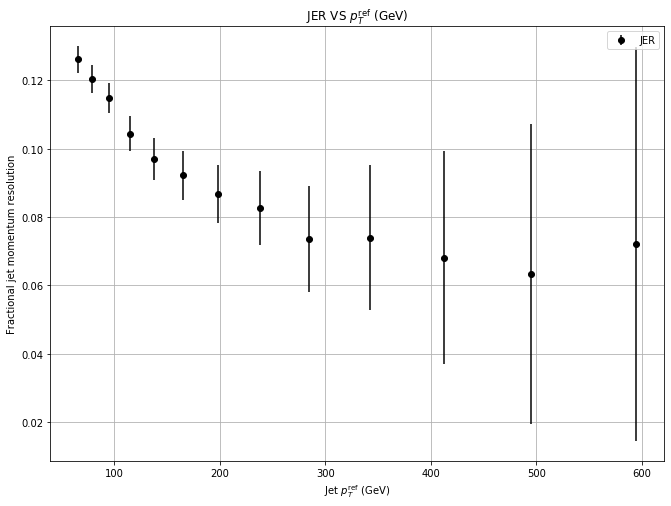

In [26]:
jer_values = np.array(jer_values)
jer_error_values = np.array(jer_error_values)
pt_refs = np.array(pt_refs)



plt.figure(figsize=[11,8])
plt.xlabel(r"Jet $p_T^{\mathrm{ref}}$ (GeV)")
plt.ylabel("Fractional jet momentum resolution")
plt.title(r"JER VS $p_T^{\mathrm{ref}}$ (GeV)")



plt.errorbar(pt_refs, jer_values, yerr=jer_error_values, fmt="o", color="black" , label="JER")


plt.legend()
plt.grid(True)
plt.show()

In [10]:
print(best_sigma_fit)

0.0720872085508832


In [11]:
# Higher Range Test for mean

jes_values = []
jes_error_values = []
pt_refs_mean = []

mean_values = np.linspace(0.85, 1.25, 41)
seeds = [35,542,23534,756,751312,232398,49835,5621,95867,87623]

for i, (min_pT, max_pT) in enumerate(successful_pt_bins):
    print(f"Current Processing pT range: {min_pT} - {max_pT}")
    
    truth_pT_j1_data,tree_pT_ll_data,tree_pT_j1_data = extracting_data(tree, min_pT, max_pT)

    #checking to see if there are enough events
    
    if len(truth_pT_j1_data)<100:
        print(f"pT range: {min_pT} - {max_pT} skipped due to low number of events")
        continue



    sig = jer_values[i]
    
    if sig <= 0:
        print(f"pT range: {min_pT} - {max_pT} skipped due to non positive sigma")
        continue
    
    #To store (seed, chi_square values)
    chi_square_results = []


    for seed in seeds:
        chi2_values=[]
        for mean in (mean_values):

            hist_truth,hist_convoluted,hist_reconstructed = fastConvoluteHistos(truth_pT_j1_data,tree_pT_ll_data,tree_pT_j1_data,sig,mean,seed)
            chi_square_point = chi_squared_manual(hist_convoluted,hist_reconstructed)
            chi2_values.append(chi_square_point)

        chi_square_results.append((seed,chi2_values))
        
        
    best_means=[]
    best_chi2_values=[]
    max_chi2_overall = 0
    
    for seed, chi2_values in (chi_square_results):
        min_chi2 = min(chi2_values)
        min_chi2_index = chi2_values.index(min_chi2)
        best_mean = mean_values[min_chi2_index]

        best_means.append(best_mean)
        best_chi2_values.append(min_chi2)

        max_chi2 = max(chi2_values)
        if max_chi2 > max_chi2_overall:
            max_chi2_overall = max_chi2  # update if current max is larger

        print("Seed: ", seed)
        print("The minimum chi-square value is ", min_chi2)
        print("The corresponding mean value is ", best_mean)
    
    
    print(best_means)
    print(best_chi2_values)
    print("Overall Max Chi2 Value: ", max_chi2_overall)


    delta_chi2 = 0.02*max_chi2_overall
    zoomed_in_range=[]

    for i in range(len(chi_square_results)):
        seed, chi2_values = chi_square_results[i]
        chi2_min = best_chi2_values[i]
        threshold = chi2_min+delta_chi2

        valid_index=[]

        for j in range(len(chi2_values)):
            if chi2_values[j] < threshold:
                valid_index.append(j)

        if valid_index:
            zoomed_in_mean_i = mean_values[min(valid_index)]
            zoomed_in_mean_f = mean_values[max(valid_index)]

        else:
            zoomed_in_mean_i = best_sigma-0.010
            zoomed_in_mean_f = best_sigma+0.010

        zoomed_in_range.append((zoomed_in_mean_i, zoomed_in_mean_f))

    print("Zoomed in range: ", zoomed_in_range)

    fixed_zoomed_in_mean_i = min([r[0] for r in zoomed_in_range])
    fixed_zoomed_in_mean_f = max([r[1] for r in zoomed_in_range])
    print(f"Fixed Zoomed in range: {fixed_zoomed_in_mean_i} to {fixed_zoomed_in_mean_f}")


    # Zooming in at minimum


    chi_square_results_zoom = []
    sig = best_sigma_fit

    mean_values_zoom = np.linspace(fixed_zoomed_in_mean_i, fixed_zoomed_in_mean_f, 100)

    for seed in seeds:
        chi2_values_zoom = []

        for mean in (mean_values_zoom):
            hist_truth,hist_convoluted,hist_reconstructed = fastConvoluteHistos(truth_pT_j1_data,tree_pT_ll_data,tree_pT_j1_data,sig,mean,seed)
            chi_square_point = chi_squared_manual(hist_convoluted,hist_reconstructed)
            chi2_values_zoom.append(chi_square_point)

        chi_square_results_zoom.append(chi2_values_zoom)


    chi_square_results_zoom = np.array(chi_square_results_zoom)   
    mean_chi2 = np.mean(chi_square_results_zoom, axis=0)
    std_chi2 = np.std(chi_square_results_zoom, axis=0)
    meanErr_chi2 = std_chi2/np.sqrt(n)






    coefficients_zoomed = np.polyfit(mean_values_zoom,mean_chi2, 2)
    quadratic_fit_zoomed = np.poly1d(coefficients_zoomed)

    mean_fine_zoomed = np.linspace(min(mean_values_zoom), max(mean_values_zoom), 100)
    chi_square_fit_zoomed = quadratic_fit_zoomed(mean_fine_zoomed)

    a,b,c = coefficients_zoomed
    best_mean_fit = -b/(2*a)
    min_chi2_fit = quadratic_fit_zoomed(best_mean_fit)



    chi_square_threshold_fit = min_chi2_fit+1

    discriminant = b**2-4*a*(c-chi_square_threshold_fit)

    if(discriminant>=0):
        point1 = ((-b + np.sqrt(discriminant))/(2*a))
        point2 = ((-b - np.sqrt(discriminant))/(2*a))
        width = abs(point1 - point2)
        mean_value_err = width/2
        print(f"Best Sigma (Fit): {best_mean_fit:.5f} +/- {mean_value_err:.5f}")  
    else:
        print("No solutions found")

        continue
        
    pt_ref = (min_pT+max_pT)/2
    jes = best_mean_fit
    jes_error = mean_value_err

    jes_values.append(jes)
    jes_error_values.append(jes_error)
    pt_refs_mean.append(pt_ref)


Current Processing pT range: 60 - 72
Seed:  35
The minimum chi-square value is  16.334722827972215
The corresponding mean value is  1.06
Seed:  542
The minimum chi-square value is  17.870322609897823
The corresponding mean value is  1.06
Seed:  23534
The minimum chi-square value is  16.48651097205226
The corresponding mean value is  1.06
Seed:  756
The minimum chi-square value is  15.608969273211866
The corresponding mean value is  1.06
Seed:  751312
The minimum chi-square value is  16.599193971825176
The corresponding mean value is  1.06
Seed:  232398
The minimum chi-square value is  16.174169224739227
The corresponding mean value is  1.06
Seed:  49835
The minimum chi-square value is  14.91732673315297
The corresponding mean value is  1.06
Seed:  5621
The minimum chi-square value is  16.211174869891362
The corresponding mean value is  1.06
Seed:  95867
The minimum chi-square value is  15.639902850921915
The corresponding mean value is  1.06
Seed:  87623
The minimum chi-square value is

In [12]:
print(pt_refs_mean)
print(jes_values)
print(jes_error_values)

print(len(pt_refs_mean))
print(len(jes_values))
print(len(jes_error_values))

[66.0, 79.0, 95.0, 114.5, 137.5, 165.0, 198.0, 238.0, 285.0, 342.5, 412.5, 495.0, 595.0]
[1.0579248257256064, 1.0515470270422704, 1.046380387447024, 1.0392628823301964, 1.0334394943724918, 1.0287313186398002, 1.0246748393100396, 1.0225432507302894, 1.019034412662968, 1.0207086316625134, 1.02190209662444, 1.0177725661748303, 1.0235640730041204]
[0.00223510091840462, 0.0024483301138372715, 0.0026824284468949244, 0.003119323822725173, 0.0036545030372122644, 0.004436326973347171, 0.005463797810286719, 0.007066970380661397, 0.009419605281830279, 0.012193974557994869, 0.017977894350009627, 0.025601784057795562, 0.035891756092505056]
13
13
13


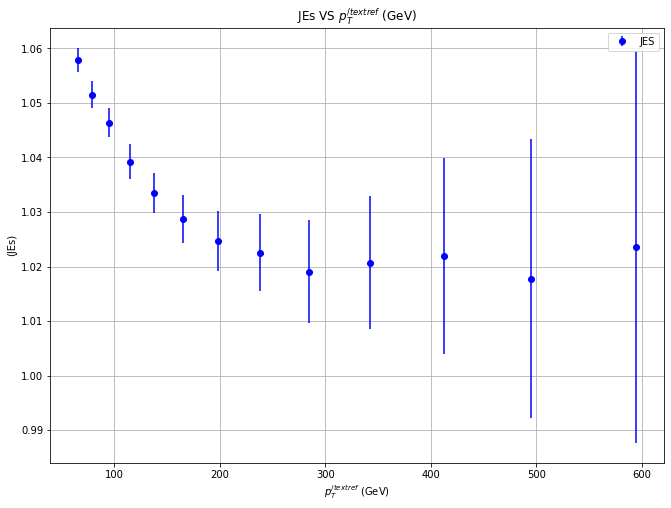

In [27]:
jes_values = np.array(jes_values)
jes_error_values = np.array(jes_error_values)
pt_refs_mean = np.array(pt_refs_mean)

plt.figure(figsize=[11,8])
plt.xlabel(r"$p_T^{/text{ref}}$ (GeV)")
plt.ylabel("(JEs)")
plt.title(r"JEs VS $p_T^{/text{ref}}$ (GeV)")

plt.errorbar(pt_refs_mean, jes_values, yerr=jes_error_values, fmt="o", color="blue" , label="JES")


plt.legend()
plt.grid(True)
plt.show()

In [14]:
def jer_curve_fit(p_T, N, S, C):
    y= (N/(p_T**2))+(S/p_T)+C
    
    return y

In [32]:
print(pt_refs)

[ 66.   79.   95.  114.5 137.5 165.  198.  238.  285.  342.5 412.5 495.
 595. ]


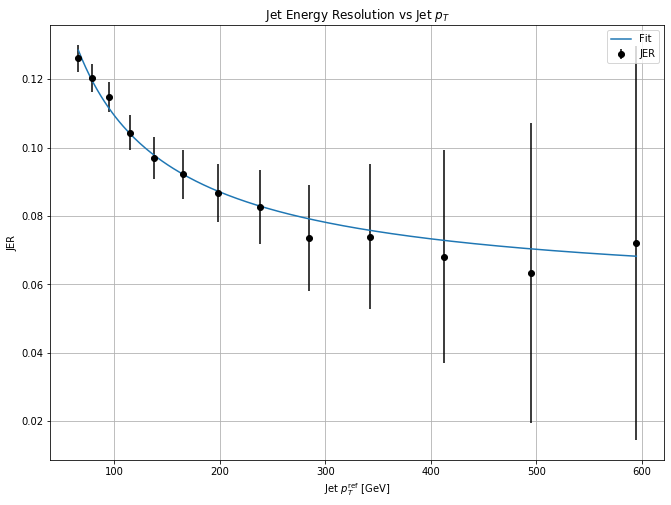

N (Noise): 0.0000 ± 0.0000
S (Sampling): 0.9381 ± 0.0574
C (Constant): 0.0564 ± 0.0097


In [38]:
def jer_curve_fit(p_T, N, S, C):
    return np.sqrt((N / p_T)**2 + (S / np.sqrt(p_T))**2 + C**2)

# Bounded and weighted fit
param, cov = curve_fit(jer_curve_fit, pt_refs, jer_values,
                       sigma=jer_error_values,
                       absolute_sigma=True,
                       bounds=([0, 0, 0], [np.inf, np.inf, np.inf]))

fit_N, fit_S, fit_C = param
fit_errs = np.sqrt(np.diag(cov))

# Smooth fit for better curve
pt_smooth = np.linspace(min(pt_refs), max(pt_refs), 300)
fit_y = jer_curve_fit(pt_smooth, fit_N, fit_S, fit_C)

# Plot
plt.figure(figsize=[11,8])
plt.xlabel(r"Jet $p_T^{\mathrm{ref}}$ [GeV]")
plt.ylabel("JER")
plt.title("Jet Energy Resolution vs Jet $p_T$")

plt.errorbar(pt_refs, jer_values, yerr=jer_error_values, fmt="o", color="black", label="JER")
plt.plot(pt_smooth, fit_y, '-', label='Fit')
plt.legend()
plt.grid(True)
plt.show()

# Print fit results
print(f"N (Noise): {fit_N:.4f} ± {fit_errs[0]:.4f}")
print(f"S (Sampling): {fit_S:.4f} ± {fit_errs[1]:.4f}")
print(f"C (Constant): {fit_C:.4f} ± {fit_errs[2]:.4f}")


In [22]:
N_err, S_err, C_err = np.sqrt(np.diag(cov)) 

print(f"N (noise): {fit_A} +/- {N_err}")
print(f"S (sampling): {fit_B} +/- {S_err}")
print(f"C (constant): {fit_C} +/- {C_err}")

N (noise): -162.5425604072063 +/- 53.93154587748052
S (sampling): 7.325075840199444 +/- 0.8791344082150213
C (constant): 0.053401866326501034 +/- 0.0027838605895887745


In [23]:
def jes_curve_fit(p_T, N, S, C):
    y= (N/(p_T**2))+(S/p_T)+C
    
    return y

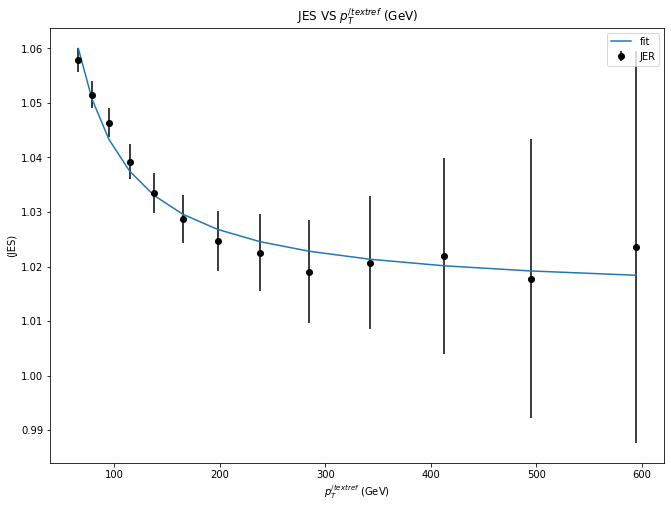

In [24]:
param, cov = curve_fit(jes_curve_fit, pt_refs_mean, jes_values)
fit_A = param[0]
fit_B = param[1]
fit_C = param[2]
plt.figure(figsize=[11,8])
fit_y = jes_curve_fit(pt_refs_mean, fit_A, fit_B, fit_C)
#plt.xscale("log")
plt.xlabel(r"$p_T^{/text{ref}}$ (GeV)")
plt.ylabel("(JES)")
plt.title(r"JES VS $p_T^{/text{ref}}$ (GeV)")

plt.errorbar(pt_refs_mean, jes_values, yerr=jes_error_values, fmt="o", color="black" , label="JER")
plt.plot(pt_refs, fit_y, '-', label='fit')
plt.legend()



In [25]:
N_err, S_err, C_err = np.sqrt(np.diag(cov)) 

print(f"N (noise): {fit_A} +/- {N_err}")
print(f"S (sampling): {fit_B} +/- {S_err}")
print(f"C (constant): {fit_C} +/- {C_err}")

N (noise): 58.51970432831304 +/- 48.32961626092643
S (sampling): 2.1016106484112345 +/- 0.7878175475363826
C (constant): 1.0147090940874357 +/- 0.0024946986410259576
